# Set up

Python librairies imports :

In [1]:
# File system management
import os
from pathlib import Path
import io

# Data manipulation
import numpy as np
import pandas as pd
from typing import Iterator

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation
from PIL import Image

# Dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Pyspark
from pyspark.ml.feature import PCA as pyPCA
from pyspark.ml.functions import array_to_vector, vector_to_array
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

%matplotlib inline
sns.set_theme(palette="Set2")

Define work location :

In [2]:
# Current project path
PATH_PROJ = "/Users/victor/Documents/OPENCLASSROOMS/projet_8"

# Define images paths
PATH_DATA = PATH_PROJ + "/data/training"
PATH_RESULTS = PATH_PROJ + "/data/results"

# Change directory
os.chdir(PATH_PROJ)

# Data exploration

In [3]:
# Count images
img_count = len([f for f in Path(PATH_DATA).rglob('*.jpg') if f.is_file()])
print("Number of JPG files in " + PATH_DATA + " : " + str(img_count))

Number of JPG files in /Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training : 6231


In [4]:
# Create list of images
images_list = [(file_name, dir_path.split('/')[-1]) for (dir_path, _, file_names) in os.walk(PATH_DATA) \
               for file_name in file_names if file_name.endswith('.jpg')]

# Create dataframe
images_df = pd.DataFrame(images_list, columns=['image', 'label'])

# Add categories
images_df['category'] = images_df['label'].apply(lambda x: x.split('_')[0]) 
display(images_df.head())

,image,label,category
0,r0_190.jpg,cucumber_3,cucumber
1,r0_184.jpg,cucumber_3,cucumber
2,r0_52.jpg,cucumber_3,cucumber
3,r0_46.jpg,cucumber_3,cucumber
4,r0_8.jpg,cucumber_3,cucumber


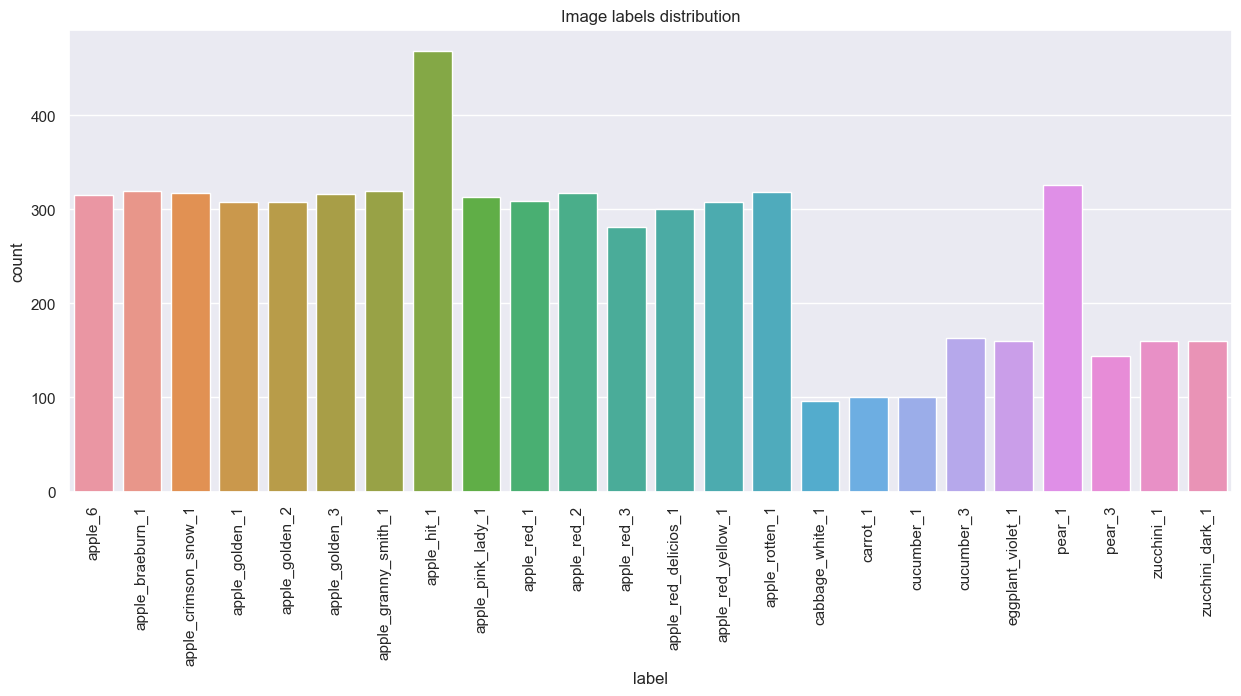

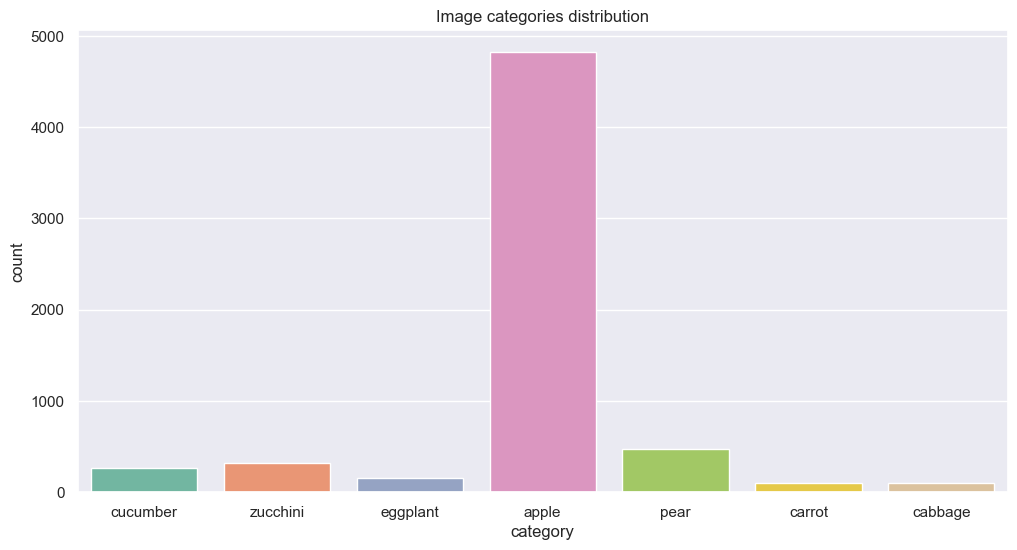

In [5]:
# Display image labels
plt.figure(figsize=(15, 6))
plt.title("Image labels distribution")
sns.countplot(x=images_df['label'].sort_values())
plt.xticks(rotation=90)
plt.show()

# Display image categories
plt.figure(figsize=(12, 6))
plt.title("Image categories distribution")
sns.countplot(x=images_df['category'])
# plt.xticks(rotation=90)
plt.show()

# Data processing

## Functions

### MobileNetV2 model

In [6]:
def model_create(show_summary=False):
    """Create a MobileNetV2 model with top layer removed

    Returns:
        MobileNetV2 model
    """
    # Load default model
    model_base = MobileNetV2(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

    # Freeze layers
    for layer in model_base.layers:
        layer.trainable = False

    # Create model without top layer
    model_new = Model(inputs=model_base.input, outputs=model_base.layers[-2].output)

    # Show model summary
    if show_summary is True:
        print(model_new.summary())

    return model_new

### Images preprocesssing

In [7]:
def preprocess(content):
    """Preprocesses raw image bytes.

    Args:
        content: PIL Image

    Returns:
        Numpy array
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [8]:
def featurize_series(model, content_series):
    """Featurize a pd.Series of raw images using the input model.

    Args:
        model: CNN model
        content_series: pd.Series of image data

    Returns:
        pd.Series of image features
    """
    content_input = np.stack(content_series.map(preprocess))
    preds = model.predict(content_input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

## Distributed model inference

### Create the Spark session

In [9]:
# Create sparkSession
spark = (SparkSession
         .builder
         .appName('oc_p8')
         .master('local')
         .config("spark.sql.parquet.writeLegacyFormat", 'true')
         .config("spark.driver.bindAddress","127.0.0.1")
         .getOrCreate())

# Create sparkContext
sc = spark.sparkContext

# Set log level
sc.setLogLevel("WARN")

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/09 17:26:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Broadcast the model weights

In [10]:
# Broadcast weights of mobile net v2 model
broadcast_weights = spark.sparkContext.broadcast(model_create(show_summary=True).get_weights())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
@F.pandas_udf("array<float>")
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """This method is a Scalar Iterator pandas UDF wrapping our featurization function.
        The decorator specifies this returns a Spark DataFrame column of type ArrayType(FloatType).

    Args:
        content_series_iter: Iterator over batches of data, where each batch
                            is a pandas Series of image data.

    Yields:
        pd.Series of image features
    """
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_create()
    # Broadcast weights to workers
    model.set_weights(broadcast_weights.value)
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

### Load the images

In [12]:
# Load all images
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_DATA)

In [13]:
# Display first images
images = images.withColumn('label', F.element_at(F.split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))
print("Number of images loaded : ", images.count())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+-----------------------------------------------------------------------------------------+-----------+
|path                                                                                     |label      |
+-----------------------------------------------------------------------------------------+-----------+
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_116.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_114.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_108.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_118.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_120.jpg|apple_hit_1|
+-----------------------------------------------------------------------------------------+-----------+
only showing top 5 rows

None


Number of images loaded :  6231


### Run the model inference

In [14]:
# Select 10% of dataset for local test
images_sample = images.sample(fraction=0.1, seed=42)
display(images_sample.show(5))
display(images_sample.printSchema())
print("Number of images : ", images_sample.count())

+--------------------+-------------------+------+--------------------+-----------+
|                path|   modificationTime|length|             content|      label|
+--------------------+-------------------+------+--------------------+-----------+
|file:/Users/victo...|2021-09-12 19:23:44|122551|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:44|121791|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:44|121719|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:46|117596|[FF D8 FF E0 00 1...|apple_hit_1|
|file:/Users/victo...|2021-09-12 19:23:46|116341|[FF D8 FF E0 00 1...|apple_hit_1|
+--------------------+-------------------+------+--------------------+-----------+
only showing top 5 rows



None

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



None

Number of images :  627


In [15]:
# Create the image features
features_df = images_sample.repartition(20).select(F.col("path"), F.col("label"),
                                                   featurize_udf("content").alias('features'))

# Create the vectors
features_df = features_df.withColumn('features_vec', array_to_vector("features"))

display(features_df.show(5))
display(features_df.printSchema())

2023-03-09 17:27:43.927544: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|        features_vec|
+--------------------+-----------+--------------------+--------------------+
|file:/Users/victo...|apple_hit_1|[0.3222898, 0.459...|[0.32228979468345...|
|file:/Users/victo...|apple_hit_1|[1.1753603, 0.059...|[1.17536032199859...|
|file:/Users/victo...| cucumber_3|[1.5150166, 0.201...|[1.51501655578613...|
|file:/Users/victo...|apple_red_3|[0.5331319, 0.003...|[0.53313189744949...|
|file:/Users/victo...|     pear_3|[0.6971466, 0.223...|[0.69714659452438...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



None

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



None

In [16]:
# Save results as parquet files
features_df.write.mode("overwrite").parquet(PATH_RESULTS + "/Features_output")

2023-03-09 17:27:55.989772: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Dimension reduction

In [17]:
# Load results as a dataframe
res_df = pd.read_parquet(PATH_RESULTS, engine='pyarrow')

display(res_df.head())

,path,label,features,features_vec
0,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_hit_1,"[0.3222898, 0.45961368, 0.06672078, 0.0, 0.012...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_hit_1,"[1.1753603, 0.059681173, 0.76340306, 0.0, 0.02...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,cucumber_3,"[1.5150166, 0.20115007, 0.0851328, 0.000481274...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_red_3,"[0.5331319, 0.0039223554, 0.0039826315, 0.0, 0...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,pear_3,"[0.6971466, 0.22352776, 0.23542322, 0.0, 0.0, ...","{'type': 1, 'size': None, 'indices': None, 'va..."


In [18]:
# Number features
features_n = res_df.loc[0, 'features'].shape[0]
print("The dimension of the features is", features_n)

The dimension of the features is 1280


### TSNE

,TSNE1,TSNE2,label
0,-10.619903,-16.664017,apple_hit_1
1,-17.982880,-4.693673,apple_hit_1
2,-37.504292,3.975001,cucumber_3
3,23.513620,-16.609869,apple_red_3
4,8.826571,-26.879221,pear_3


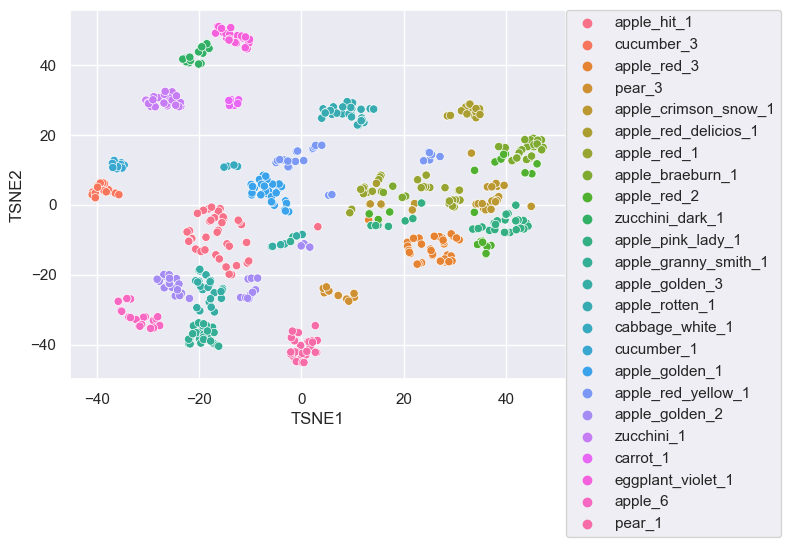

In [19]:
# Extract features
features = pd.DataFrame(res_df['features'].values.tolist(), index=res_df.index)

# Create t-sne dataframe
tsne_df = pd.DataFrame(TSNE(perplexity=20).fit_transform(features), columns=['TSNE1', 'TSNE2'])

# Add label
tsne_df['label'] = res_df['label']
display(tsne_df.head())

# Display scatterplot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='label')
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.show()

### Sklearn PCA

In [20]:
# Number of components
PCA_K = 100

In [21]:
# Create PCA model
pca = PCA(n_components=PCA_K)

# Fit to data 
pca_data = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_data, columns=['PCA'+str(i) for i in range(1, pca_data.shape[1]+1)])
display(pca_df.head())


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99,PCA100
0,-5.406527,-6.325714,3.277804,1.652383,-1.239281,4.288006,1.269369,-4.382627,1.615670,0.599282,...,-0.613158,0.532186,-0.214750,-0.193036,-0.258093,0.619858,0.448179,-0.262525,-0.841360,-0.460361
1,-6.856067,-2.294329,-2.866752,-2.737640,1.549399,3.624322,1.760000,-3.727621,-2.141588,2.609685,...,-0.393091,0.074157,0.167557,0.183462,0.630604,0.055772,0.424407,-0.286477,0.355389,-0.481519
2,-6.793596,6.898500,2.120465,-7.872385,2.867374,4.054109,-5.980983,4.276623,0.890354,-3.616581,...,0.205177,0.057628,-0.077547,-0.349420,0.053548,-0.218594,-0.052998,-0.109093,-0.293326,0.561508
3,4.206676,-1.385414,-1.109062,0.360154,3.286686,0.513464,1.780775,-0.205088,-3.028671,-2.126358,...,-0.052013,-0.190631,-0.116556,0.035299,0.026651,0.076812,0.917565,-0.101902,-0.637222,0.649048
4,1.424646,-3.818303,2.080119,-2.695065,5.127028,1.514165,-0.695915,-4.071552,0.801474,0.268114,...,0.010141,0.018677,-0.095567,-0.864574,0.511012,-0.388190,-0.397185,-0.013430,0.013573,0.266869


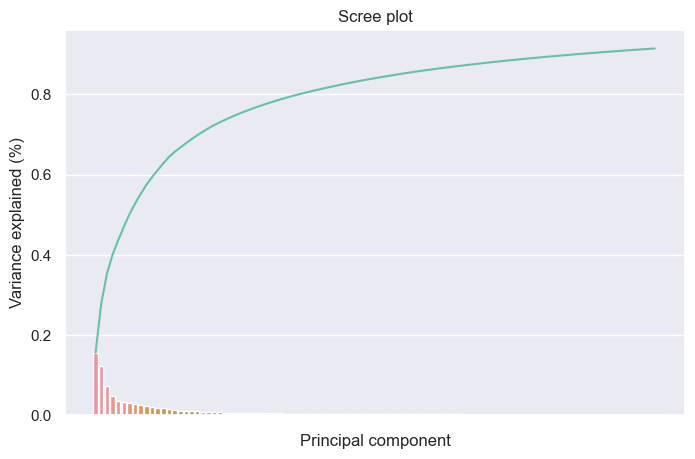

In [22]:
# Get explained variance ratio
pca_evr = list(pca.explained_variance_ratio_)
pca_evr_cumsum = np.cumsum(pca_evr)

# Display 
plt.figure(figsize=(8, 5))
plt.title("Scree plot")
sns.barplot(x=pca_df.columns, y=pca_evr)
sns.lineplot(x=pca_df.columns, y=pca_evr_cumsum)
plt.xlabel('Principal component')
plt.xticks('')
plt.ylabel('Variance explained (%)')
plt.show()

In [23]:
# Find thresholds
for th_val in [0.8, 0.85, 0.90, 0.95, 100]:
    th_idx = np.argmax(pca_evr_cumsum > th_val)
    if th_idx > 0:
        print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(th_val, th_idx+1, pca_evr_cumsum[th_idx]))

# Show 100e component
print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(pca_evr_cumsum[99], 100, pca_evr_cumsum[99]))


80% of the variance is explained by 37 principal components (0.8003)
85% of the variance is explained by 55 principal components (0.8512)
90% of the variance is explained by 86 principal components (0.9002)
91% of the variance is explained by 100 principal components (0.9146)


### Pyspark PCA

In [ ]:
# Create pyspark PCA model
pca = pyPCA(k=PCA_K, inputCol='features_vec', outputCol='features_pca')

# Fit model
pca_model = pca.fit(features_df)

# Transform data
features_df = pca_model.transform(features_df)

display(features_df.show(5))
display(features_df.printSchema())

In [ ]:
display(features_df.show(5))
display(features_df.printSchema())

2023-03-09 13:57:15.587556: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|        features_vec|
+--------------------+-----------+--------------------+--------------------+
|file:/Users/victo...|apple_hit_1|[0.3222898, 0.459...|[0.32228979468345...|
|file:/Users/victo...|apple_hit_1|[1.1753603, 0.059...|[1.17536032199859...|
|file:/Users/victo...| cucumber_3|[1.5150166, 0.201...|[1.51501655578613...|
|file:/Users/victo...|apple_red_3|[0.5331319, 0.003...|[0.53313189744949...|
|file:/Users/victo...|     pear_3|[0.6971466, 0.223...|[0.69714659452438...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



None

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



None

In [ ]:
# Save PCA output as single json file
features_df.select(F.col('features_pca')).withColumn('features_pca', vector_to_array('features_pca')) \
    .repartition(1) \
    .write \
    .mode("overwrite") \
    .json(PATH_RESULTS + "/PCA_output")